In [1]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import re
from collections import Counter

# VEST OH 2020
---

## VEST Documentation

### Election Results

#### Sources
Election results from the Ohio Secretary of State (https://www.sos.state.oh.us/elections/election-results-and-data/). 

#### Processing Part 1
The following counties include adjustments to account for corporate annexations that are not specified below by precinct: Adams, Athens, Butler, Franklin, Guernsey, Montgomery, Stark, Tuscarawas, Warren, Wayne.

#### Processing Part 2 (unclear whether this is for election results, shapefiles, or both)
The following additional revisions were made to match the 2020 precinct boundaries:

- **Athens:** Adjust Athens 4-4/4-5, Nelsonville 1/2/3/4
- **Brown:** Adjust Perry Twp South/Villages
- **Butler:** Adjust Hamilton 22/24, Oxford 6/11, Trenton 5/7, West Chester 28/39
- **Champaign:** Adjust Union N/S
- **Clark:** Align New Carlisle, Springfield precincts with county maps
- **Crawford:** Move eastern Polk Twp from Galion 1B to western Polk Twp
- **Cuyahoga:** Adjust Olmsted Twp D/F/H
- **Delaware:** Adjust Berlin C/Delaware 3-F
- **Fairfield:** Adjust Greenfield B/Lancaster 2-A, Pickerington F/Violet B/Violet C
- **Greene:** Adjust Bath 277/Fairborn 226/Xenia 351
- **Hamilton:** Adjust Cleves A/Whitewater A, Colerain BB/F
- **Knox:** Adjust Clinton A/Mount Vernon 1-B, Clinton B/Mount Vernon 2-A
- **Lake:** Adjust Painesville A/K
- **Medina:** Adjust Wadsworth City 1-D/Sharon D, Wadsworth City 2-D/Twp C
- **Richland:** Adjust Ontario 3/4
- **Stark:** Adjust Canton 8-C/Plain 6, Canton 6-A/Plain 12
- **Summit:** Adjust Coventry D/G, Hudson 1-B/3-C, Springfield F/J
- **Warren:** Adjust Mason City Z/Union A, South Lebanon A/B

#### Races
G20PRERTRU - Donald J. Trump (Republican Party)  
G20PREDBID - Joseph R. Biden (Democratic Party)  
G20PRELJOR - Jo Jorgensen (Libertarian Party)  
G20PREGHAW - Howie Hawkins (Independent)  

### Shapefiles

#### Sources
Precinct shapefile from the U.S. Census Bureau's 2020 Redistricting Data Program final release. Note that some VTDs were relabeled to match precinct names and/or precinct codes in the November 2020 general election returns.

# Election Result Processing

## Get VEST file and FIPS dictionary ready

### Load in VEST file

In [2]:
vest_oh_20 = gp.read_file("./raw-from-source/VEST/oh_2020/oh_2020.shp")

In [3]:
vest_oh_20.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

<AxesSubplot:>

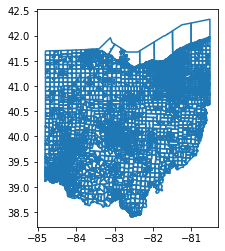

In [4]:
vest_oh_20.boundary.plot()

In [5]:
vest_oh_20.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'PRECINCT20', 'GEOID20', 'NAME20',
       'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'G20PREGHAW', 'geometry'],
      dtype='object')

### Create a FIPs dictionary for OH

In [6]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Ohio"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Create the dictionary
oh_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

## Load and Clean Election Results

### Load Election Results

Cleaned the `statewideresultsbyprecinct.xlsx` file by hand, and created `statewideresultsbyprecinct_clean.csv`. No modifications were made to the election results. Unnecessary tabs were removed and column names were renamed to match VEST's manually. 

In [7]:
#Load in clean SOS file
dem_elections_2020 = pd.read_excel("./raw-from-source/SOS/democratprecinctall.xlsx",sheet_name="Master")
rep_elections_2020 = pd.read_excel("./raw-from-source/SOS/republicanprecinct.xlsx",sheet_name="Master")
lib_elections_2020 = pd.read_excel("./raw-from-source/SOS/libertarianprecinctall.xlsx",sheet_name="Master")

In [8]:
dem_elections_2020.head()

,"March 17, 2020 Primary Election Official Canvass\n*Results for write-in (WI) candidates will not be available on election night.\n*Write-in candidates will be displayed with a (WI) designation and not party affiliation.\n*Precinct-level data is not available for write-in candidates. To view results for write-in candidates, download the Summary-level spreadsheet.",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,President (at-large)\n,Unnamed: 9,...,State Representative - District 88\n,State Representative - District 89\n,State Representative - District 91\n,State Representative - District 92\n,State Representative - District 94\n,State Representative - District 96\n,Unnamed: 193,State Representative - District 97\n,State Representative - District 98\n,State Representative - District 99\n
0,County Name,Precinct Name,Precinct Code,Region Name,Media Market,Registered Voters,Total Voters,Turnout Percentage,Michael Bennet (D),Joseph R. Biden Jr (D),...,Chris Liebold (D),Alexis Miller (D),Scott M. Dailey (D),Beth Workman (D),Katie O'Neill (D),Charlie DiPalma (D),Richard A. Olivito (D),Alaina Swope (D),Todd E Beegle (D),Richard Dana (D)
1,Total,NaN,NaN,NaN,NaN,7774767,1834465,0.235951,2030,647284,...,5473,7769,3225,4669,5356,4359,5370,4139,4870,5836
2,Percentage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002271,0.724128,...,1,1,1,1,1,0.448042,0.551958,1,1,1
3,Adams,BRATTON TOWNSHIP,AAA,Southwest,Cincinnati,904,241,0.266593,0,42,...,0,0,0,0,0,0,0,0,0,0
4,Adams,BRUSH CREEK TOWNSHIP,AAB,Southwest,Cincinnati,749,183,0.244326,0,36,...,0,0,0,0,0,0,0,0,0,0


In [9]:
def clean_oh_import(dataframe):
    
    corrected_col_names = []
    for index in range(0,len(dataframe.columns)):
        col_name = dataframe.columns[index]
        col_name = col_name.replace("\n"," ")
        if "Unnamed" in col_name:
            corrected_col_names.append(corrected_col_names[index-1])
        else:
            corrected_col_names.append(col_name)
    dataframe.columns = corrected_col_names
    
    corrected_col_names = []
    for index in range(0,len(dataframe.columns)):
        col = dataframe.columns[index]
        first_row = dataframe.iloc[0,index]
        if (index > 7):
            new_column_name = col + " " + first_row 
            corrected_col_names.append(new_column_name)
        else:
            corrected_col_names.append(first_row)
    dataframe.columns = corrected_col_names
    
    dataframe = dataframe.iloc[3:,]
    return dataframe

In [10]:
dem_elections_2020_clean = clean_oh_import(dem_elections_2020)
rep_elections_2020_clean = clean_oh_import(rep_elections_2020)
lib_elections_2020_clean = clean_oh_import(lib_elections_2020)

In [11]:
for val in [dem_elections_2020_clean,rep_elections_2020_clean,lib_elections_2020_clean]:
    print(val.shape)
    val["UNIQUE_ID"] = val["County Name"]+"-"+val["Precinct Code"]

(8933, 197)
(8933, 226)
(8933, 15)


<ipython-input-11-e60a347620bc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val["UNIQUE_ID"] = val["County Name"]+"-"+val["Precinct Code"]


In [12]:
col_check_1 = rep_elections_2020_clean["UNIQUE_ID"] == lib_elections_2020_clean["UNIQUE_ID"]
col_check_2 = lib_elections_2020_clean["UNIQUE_ID"] == dem_elections_2020_clean["UNIQUE_ID"]

In [13]:
rep_elections_2020_clean.columns

Index(['County Name', 'Precinct Name', 'Precinct Code', 'Region Name',
       'Media Market', 'Registered Voters', 'Total Voters',
       'Turnout Percentage', 'President (at-large)  Donald J. Trump (R)',
       'President (district) - District 01  Donald J. Trump (R)',
       ...
       'State Representative - District 92  Mark Johnson (R)',
       'State Representative - District 93  Jeff Halley (R)',
       'State Representative - District 93  Jason C. Stephens (R)',
       'State Representative - District 94  Jay Edwards (R)',
       'State Representative - District 95  Don Jones (R)',
       'State Representative - District 96  Ron Ferguson (R)',
       'State Representative - District 97  Adam Holmes (R)',
       'State Representative - District 98  Brett Hudson Hillyer (R)',
       'State Representative - District 99  Sarah E. Fowler (R)', 'UNIQUE_ID'],
      dtype='object', length=227)

In [14]:
rep_elections_2020_clean.drop(['County Name', 'Precinct Name', 'Precinct Code', 'Region Name','Media Market', 'Registered Voters','Total Voters','Turnout Percentage',"UNIQUE_ID"],inplace=True,axis=1)
lib_elections_2020_clean.drop(['County Name', 'Precinct Name', 'Precinct Code', 'Region Name','Media Market', 'Registered Voters','Total Voters','Turnout Percentage',"UNIQUE_ID"],inplace=True,axis=1)

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [15]:
combined = pd.concat([dem_elections_2020_clean,rep_elections_2020_clean,lib_elections_2020_clean],axis=1)

In [16]:
elections_2020 = combined.copy(deep=True)

In [17]:
#Map to the correct FIP
elections_2020["COUNTYFP"]=elections_2020["County Name"].map(oh_fips_dict).fillna(elections_2020["County Name"])

#Print out the FIPS to make sure they all are in the correct format
elections_2020["COUNTYFP"].unique()

array(['001', '003', '005', '007', '009', '011', '013', '015', '017',
       '019', '021', '023', '025', '027', '029', '031', '033', '035',
       '037', '039', '041', '043', '045', '047', '049', '051', '053',
       '055', '057', '059', '061', '063', '065', '067', '069', '071',
       '073', '075', '077', '079', '081', '083', '085', '087', '089',
       '091', '093', '095', '097', '099', '101', '103', '105', '107',
       '109', '111', '113', '115', '117', '119', '121', '123', '125',
       '127', '129', '131', '133', '135', '137', '139', '141', '143',
       '145', '147', '149', '151', '153', '155', '157', '159', '161',
       '163', '165', '167', '169', '171', '173', '175'], dtype=object)

In [18]:
filter_out_cols = [i for i in elections_2020.columns if ("Judge of the Court of Appeals - District" in i or "Member of the State Board of Education - District" in i or "WI" in i)]


In [19]:
elections_2020 = elections_2020[[i for i in elections_2020.columns if i not in filter_out_cols]]

## Look into split precincts

In [20]:
def get_level_dist(column_name):
    if "Representative to Congress" in column_name:
        level = "CON"
    elif "State Senator" in column_name:
        level = "SU"
    elif "State Representative" in column_name:
        level = "SL"
    else:
        raise ValueError
    return_val = re.findall("District \S{2}",column_name)    
    if (len(return_val)!=0):
        dist = return_val[0].split(" ")[1]
    else:
        raise ValueError
    return level,dist

In [21]:
def is_split_precinct(district_assignment_list):
    c = Counter([x[0] for x in district_assignment_list])
    greater_than_one = {x:[y[1] for y in district_assignment_list if y[0]==x] for x, count in c.items() if count > 1}
    if len(greater_than_one)==0:
        return 0
    else:
        return greater_than_one

In [22]:
for col in elections_2020[[i for i in elections_2020.columns if "President (district)" in i]]:
    print(col)
    print(sum(elections_2020[[i for i in elections_2020.columns if "President" in i]][col]))

President (district) - District 01  Donald J. Trump (R)
45125
President (district) - District 02  Donald J. Trump (R)
52981
President (district) - District 03  Donald J. Trump (R)
12971
President (district) - District 04  Donald J. Trump (R)
63283
President (district) - District 05  Donald J. Trump (R)
56297
President (district) - District 06  Donald J. Trump (R)
62299
President (district) - District 07  Donald J. Trump (R)
54886
President (district) - District 08  Donald J. Trump (R)
56470
President (district) - District 09  Donald J. Trump (R)
18095
President (district) - District 10  Donald J. Trump (R)
47061
President (district) - District 11  Donald J. Trump (R)
10116
President (district) - District 12  Donald J. Trump (R)
56368
President (district) - District 13  Donald J. Trump (R)
29243
President (district) - District 14  Donald J. Trump (R)
49125
President (district) - District 15  Donald J. Trump (R)
43236
President (district) - District 16  Donald J. Trump (R)
43543


In [23]:
#Combine the republican presidential primary results into one column
elections_2020["President Donald J. Trump (R)"] = 0
for val in [i for i in elections_2020.columns if "President (district)" in i]:
    elections_2020["President Donald J. Trump (R)"] += elections_2020[val]

In [24]:
elections_2020.drop([i for i in elections_2020.columns if "President (district)" in i],axis=1,inplace=True)

In [25]:
district_cols = [i for i in elections_2020.columns if "District" in i]
elections_2020_districts = elections_2020[['COUNTYFP','Precinct Name','Precinct Code']+district_cols]

In [26]:
precinct_mapping_dict = {}
split_precincts_list = {}
for index,row in elections_2020_districts.iterrows():
    precinct_list = []
    for contest in district_cols:
        if(row[contest]!=0):
            precinct_info = get_level_dist(contest)
            if precinct_info not in precinct_list:
                precinct_list.append(get_level_dist(contest))
    is_split = is_split_precinct(precinct_list)
    if (is_split):
        split_precincts_list[row["COUNTYFP"]+"-"+row["Precinct Code"]]=is_split
    precinct_mapping_dict[row["COUNTYFP"]+"-"+row["Precinct Code"]]=precinct_list

## Rename the columns

In [27]:
list(elections_2020.columns)

['County Name',
 'Precinct Name',
 'Precinct Code',
 'Region Name',
 'Media Market',
 'Registered Voters',
 'Total Voters',
 'Turnout Percentage',
 'President (at-large)  Michael Bennet (D)',
 'President (at-large)  Joseph R. Biden Jr (D)',
 'President (at-large)  Michael R.  Bloomberg (D)',
 'President (at-large)  Pete Buttigieg (D)',
 'President (at-large)  Tulsi Gabbard (D)',
 'President (at-large)  Amy  Klobuchar (D)',
 'President (at-large)  Deval Patrick (D)',
 'President (at-large)  Bernie Sanders (D)',
 'President (at-large)  Tom Steyer (D)',
 'President (at-large)  Elizabeth Warren (D)',
 'Representative to Congress - District 01  Nikki Foster (D)',
 'Representative to Congress - District 01  Kate Schroder (D)',
 'Representative to Congress - District 02  Jaime M. Castle (D)',
 'Representative to Congress - District 03  Joyce Beatty (D)',
 'Representative to Congress - District 03  Morgan Harper (D)',
 'Representative to Congress - District 04  Shannon M. Freshour (D)',
 'Repr

## Rename Columns

In [28]:
elections_2020.columns

keep_names = ['County Name','Precinct Name','Precinct Code','Region Name','Media Market','Registered Voters','Ballots Counted','Official Voter Turnout','Total Voters','Turnout Percentage','COUNTYFP','UNIQUE_ID']

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [29]:
def get_race(contest):
    if "Justice of the Supreme Court" in contest:
        level = "SSC"
        if "Kennedy" in contest or "O'Donnell" in contest:
            level = "SSCK"
        else:
            level = "SSCF"
    elif "President" in contest:
        level = "PRE"
    elif ("Representative to Congress" in contest or "State Senator" in contest or "State Representative" in contest):
        contest_info = get_level_dist(contest)
        level = contest_info[0]+contest_info[1]
    else:
          raise ValueError
    return level

In [30]:
def get_party(contest):
    if contest == "State Representative - District 30  Tom Roll":
        return "I"
    if "Justice of the Supreme Court Term" in contest:
        if "Sharon L. Kennedy" in contest:
            return "R"
        elif "John P. O'Donnell" in contest:
            return "D"
        elif "Jennifer Brunner" in contest:
            return "D"
        elif "Judi French" in contest:
            return "R"
        else:
            print(contest)
            raise ValueError
    return_val = re.findall("\(\S\)",contest)   
    if (len(return_val)!=0):
        party = return_val[0][1]
        return party
    else:
        print(contest)
        raise ValueError

In [31]:
def get_name(contest):
    contest = contest.upper()
    contest = contest.replace("'","")
    if ("(") in contest.split(" ")[-1]:
        second_to_last = contest.split(" ")[-2]
        #second_to_last = second_to_last.replace("'","")
        if second_to_last in ["JR","III"]:
            third_to_last = contest.split(" ")[-3]
            #third_to_last = third_to_last.replace("'","")
            return third_to_last[0:3]
        else:
            return second_to_last[0:3]
    else:
        return contest.split(" ")[-1][0:3] 

In [32]:
elections_2020.drop('President Donald J. Trump (R)',axis=1,inplace=True)

In [33]:
contest_name_change_dict = {}
for contest in elections_2020.columns:
    if contest  not in keep_names or "President" in contest:
        contest_name_change_dict[contest] = "P"+get_race(contest)+get_party(contest)+get_name(contest)

In [34]:
elections_2020.rename(columns=contest_name_change_dict,inplace=True)

### Filter Down to Relevant Columns

In [35]:
keeper_columns = ['County Name','Precinct Name','Precinct Code','Region Name','Media Market','Registered Voters','COUNTYFP']
statewide_contests = [i for i in list(elections_2020.columns) if  "PSU" in i]

In [36]:
elections_2020 = elections_2020[keeper_columns+statewide_contests]

### Compare Precinct Totals

In [37]:
elections_2020["UNIQUE_ID"] = elections_2020["COUNTYFP"]+"-"+elections_2020["Precinct Code"]
vest_oh_20["UNIQUE_ID"] = vest_oh_20["COUNTYFP20"]+"-"+vest_oh_20["PRECINCT20"]

In [38]:
#Confirm unique IDs are unique
print(elections_2020["UNIQUE_ID"].value_counts(dropna=False))
print(vest_oh_20["UNIQUE_ID"].value_counts(dropna=False))

167-ABM    1
143-ADK    1
155-ADU    1
159-AAE    1
139-AAQ    1
          ..
165-AFH    1
061-AWN    1
047-AAX    1
035-BKZ    1
035-AUT    1
Name: UNIQUE_ID, Length: 8933, dtype: int64
167-ABM    1
095-AOV    1
069-AAK    1
007-AED    1
095-ARI    1
          ..
061-BNW    1
093-ACP    1
143-ABM    1
165-AEJ    1
017-AKI    1
Name: UNIQUE_ID, Length: 8941, dtype: int64


In [39]:
attempt_one = pd.merge(vest_oh_20,elections_2020,how="outer",on="UNIQUE_ID",indicator=True)
print(attempt_one["_merge"].value_counts())

vest_only  = attempt_one[attempt_one["_merge"]=="left_only"]
elections_only = attempt_one[attempt_one["_merge"]=="right_only"]

both          8933
left_only        8
right_only       0
Name: _merge, dtype: int64


In [40]:
attempt_one.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'PRECINCT20', 'GEOID20', 'NAME20',
       'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'G20PREGHAW', 'geometry',
       'UNIQUE_ID', 'County Name', 'Precinct Name', 'Precinct Code',
       'Region Name', 'Media Market', 'Registered Voters', 'COUNTYFP',
       'PSU02DODO', 'PSU02DSUB', 'PSU04DWYE', 'PSU06DFOG', 'PSU06DGRI',
       'PSU08DBRO', 'PSU10DBAL', 'PSU12DPOL', 'PSU14DOTT', 'PSU16DBAI',
       'PSU16DDOU', 'PSU16DLET', 'PSU18DRAD', 'PSU20DJOH', 'PSU22DJOH',
       'PSU24DJAC', 'PSU26DSWA', 'PSU28DSYK', 'PSU30DFLE', 'PSU32DOBR',
       'PSU02RGAV', 'PSU04RKEL', 'PSU04RLAN', 'PSU04RWON', 'PSU06RANT',
       'PSU06RROB', 'PSU06RSEL', 'PSU08RBLE', 'PSU10RHAC', 'PSU12RHUF',
       'PSU14RJOH', 'PSU14RUIB', 'PSU16RKUN', 'PSU18RCIR', 'PSU20RSCH',
       'PSU22RBRA', 'PSU22RFAL', 'PSU22RHOV', 'PSU22RREY', 'PSU22RROM',
       'PSU24RDOL', 'PSU26RACK', 'PSU26RREI', 'PSU28RDOW', 'PSU30RHOA',
       'PSU32ROBR', 'PSU32RPOL', '_merge'],
      dtype='

In [41]:
#Confirm these are all zero-vote races
races =["UNIQUE_ID"]

for val in ['G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'G20PREGHAW']:
    races.append(val)

print((vest_only[races]))

     UNIQUE_ID  G20PRERTRU  G20PREDBID  G20PRELJOR  G20PREGHAW
814    093-ZZZ           0           0           0           0
982    123-ZZZ           0           0           0           0
2924   095-ZZZ           0           0           0           0
3674   043-ZZZ           0           0           0           0
4389   085-ZZZ           0           0           0           0
4565   035-ZZZ           0           0           0           0
5357   133-ZZZ           0           0           0           0
7951   007-ZZZ           0           0           0           0


## Clean up the unjoined results

In [42]:
attempt_one.drop(["_merge",'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'G20PREGHAW'],inplace=True,axis=1)

In [43]:
final_race_list = ['PSU02DODO', 'PSU02DSUB', 'PSU04DWYE', 'PSU06DFOG', 'PSU06DGRI',
       'PSU08DBRO', 'PSU10DBAL', 'PSU12DPOL', 'PSU14DOTT', 'PSU16DBAI',
       'PSU16DDOU', 'PSU16DLET', 'PSU18DRAD', 'PSU20DJOH', 'PSU22DJOH',
       'PSU24DJAC', 'PSU26DSWA', 'PSU28DSYK', 'PSU30DFLE', 'PSU32DOBR',
       'PSU02RGAV', 'PSU04RKEL', 'PSU04RLAN', 'PSU04RWON', 'PSU06RANT',
       'PSU06RROB', 'PSU06RSEL', 'PSU08RBLE', 'PSU10RHAC', 'PSU12RHUF',
       'PSU14RJOH', 'PSU14RUIB', 'PSU16RKUN', 'PSU18RCIR', 'PSU20RSCH',
       'PSU22RBRA', 'PSU22RFAL', 'PSU22RHOV', 'PSU22RREY', 'PSU22RROM',
       'PSU24RDOL', 'PSU26RACK', 'PSU26RREI', 'PSU28RDOW', 'PSU30RHOA',
       'PSU32ROBR', 'PSU32RPOL']

In [44]:
attempt_one.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'PRECINCT20', 'GEOID20', 'NAME20',
       'geometry', 'UNIQUE_ID', 'County Name', 'Precinct Name',
       'Precinct Code', 'Region Name', 'Media Market', 'Registered Voters',
       'COUNTYFP', 'PSU02DODO', 'PSU02DSUB', 'PSU04DWYE', 'PSU06DFOG',
       'PSU06DGRI', 'PSU08DBRO', 'PSU10DBAL', 'PSU12DPOL', 'PSU14DOTT',
       'PSU16DBAI', 'PSU16DDOU', 'PSU16DLET', 'PSU18DRAD', 'PSU20DJOH',
       'PSU22DJOH', 'PSU24DJAC', 'PSU26DSWA', 'PSU28DSYK', 'PSU30DFLE',
       'PSU32DOBR', 'PSU02RGAV', 'PSU04RKEL', 'PSU04RLAN', 'PSU04RWON',
       'PSU06RANT', 'PSU06RROB', 'PSU06RSEL', 'PSU08RBLE', 'PSU10RHAC',
       'PSU12RHUF', 'PSU14RJOH', 'PSU14RUIB', 'PSU16RKUN', 'PSU18RCIR',
       'PSU20RSCH', 'PSU22RBRA', 'PSU22RFAL', 'PSU22RHOV', 'PSU22RREY',
       'PSU22RROM', 'PSU24RDOL', 'PSU26RACK', 'PSU26RREI', 'PSU28RDOW',
       'PSU30RHOA', 'PSU32ROBR', 'PSU32RPOL'],
      dtype='object')

In [45]:
for race in final_race_list:
    attempt_one[race] = attempt_one[race].fillna(0)
    attempt_one[race] = attempt_one[race].astype(int)

## Sort the columns to match what VEST has

In [46]:
attempt_one = attempt_one[['UNIQUE_ID','COUNTYFP','STATEFP20', 'COUNTYFP20', 'VTDST20', 'PRECINCT20', 'GEOID20', 'NAME20','PSU02DODO', 'PSU02DSUB', 'PSU04DWYE', 'PSU06DFOG', 'PSU06DGRI',
       'PSU08DBRO', 'PSU10DBAL', 'PSU12DPOL', 'PSU14DOTT', 'PSU16DBAI',
       'PSU16DDOU', 'PSU16DLET', 'PSU18DRAD', 'PSU20DJOH', 'PSU22DJOH',
       'PSU24DJAC', 'PSU26DSWA', 'PSU28DSYK', 'PSU30DFLE', 'PSU32DOBR',
       'PSU02RGAV', 'PSU04RKEL', 'PSU04RLAN', 'PSU04RWON', 'PSU06RANT',
       'PSU06RROB', 'PSU06RSEL', 'PSU08RBLE', 'PSU10RHAC', 'PSU12RHUF',
       'PSU14RJOH', 'PSU14RUIB', 'PSU16RKUN', 'PSU18RCIR', 'PSU20RSCH',
       'PSU22RBRA', 'PSU22RFAL', 'PSU22RHOV', 'PSU22RREY', 'PSU22RROM',
       'PSU24RDOL', 'PSU26RACK', 'PSU26RREI', 'PSU28RDOW', 'PSU30RHOA',
       'PSU32ROBR', 'PSU32RPOL',
       'geometry','County Name']]

## Add in a SLU_DIST column

Note: We know that for the SLU districts where there are election results, there are no splits, for others we don't know them

In [47]:
attempt_one["Tot_Votes"] = 0

for race in final_race_list:
    attempt_one["Tot_Votes"] += attempt_one[race]

In [48]:
attempt_one[attempt_one["Tot_Votes"]>0].shape

(4423, 58)

In [49]:
def contains_sll(dist_list):
    #print("Calling on ", dist_list)
    for dist_tuple in dist_list:
        #print("Call on ", dist_tuple)
        if dist_tuple[0] == "SU":
            #print("Found the SLU")
            return dist_tuple[1]

In [50]:
check_list = {i:contains_sll(precinct_mapping_dict[i]) for i in precinct_mapping_dict.keys()}

In [51]:
len([i for i in check_list.keys() if check_list[i]!=None])

4423

In [52]:
attempt_one["SLDU_DIST"] = attempt_one["UNIQUE_ID"].map(check_list).fillna("n/a")

In [53]:
attempt_one["SLDU_DIST"].value_counts(dropna=False)

n/a    4518
30      358
14      327
26      310
16      291
32      280
02      276
18      274
20      273
04      270
12      268
24      266
10      260
22      250
28      249
08      239
06      232
Name: SLDU_DIST, dtype: int64

## Compare assignments against the original file

In [54]:
oh_st_sen_districts = gp.read_file("./raw-from-source/District_Shapefiles/oh_pl2020_sldu/oh_pl2020_sldu.shp")

In [55]:
included_sen_races = list(attempt_one["SLDU_DIST"].unique())
included_sen_races.remove('n/a')

In [56]:
print(included_sen_races)

['30', '26', '04', '10', '02', '20', '12', '32', '14', '22', '08', '18', '06', '24', '28', '16']


In [57]:
oh_st_sen_districts["SLDU_DIST"] = oh_st_sen_districts["SLDUST20"].str[1:3]

In [58]:
filtered_sen = oh_st_sen_districts[oh_st_sen_districts["SLDU_DIST"].isin(included_sen_races)]

In [59]:
filtered_results = attempt_one[attempt_one["SLDU_DIST"].isin(included_sen_races)]

In [60]:
filtered_results = filtered_results.dissolve("SLDU_DIST")
filtered_results.reset_index(inplace=True, drop=False)

In [61]:
from matplotlib.lines import Line2D

def compare_geometries(gdf_1,gdf_2,left_gdf_name,right_gdf_name,join_col_name,area_threshold=.1):
    '''
    Function that joins to GeoDataFrames on a column and reports area differences row-by-row
    '''
    gdf_1 = gdf_1.to_crs(3857)
    gdf_2 = gdf_2.to_crs(3857)
    both = pd.merge(gdf_1,gdf_2,how="outer",on=join_col_name,validate="1:1",indicator=True)
    if(both["_merge"].str.contains("_")).any():
        print("Non-unique merge values")
        raise ValueError
    left_geoms = gp.GeoDataFrame(both,geometry="geometry_x")
    right_geoms = gp.GeoDataFrame(both,geometry="geometry_y")
    left_geoms["geometry_x"]=left_geoms.buffer(0)
    right_geoms["geometry_y"]=right_geoms.buffer(0)
    if (left_geoms.is_valid==False).any():
        raise ValueError
    elif(right_geoms.is_valid==False).any():
        raise ValueError
    count = 0
    area_list = []
    print("Checking " + str(both.shape[0])+" precincts for differences of greater than "+str(area_threshold)+" km^2")
    print()
    for index,row in both.iterrows():
        diff = left_geoms.iloc[[index]].symmetric_difference(right_geoms.iloc[[index]])
        intersection = left_geoms.iloc[[index]].intersection(right_geoms.iloc[[index]])
        area = float(diff.area/10e6)
        area_list.append(area)
        if (area > area_threshold):
            count += 1
            name = left_geoms.at[index,join_col_name]
            print(str(count)+") For " + name + " difference in area is " + str(area))
            if (intersection.iloc[0].is_empty):
                base = left_geoms.iloc[[index]].plot(color="orange",figsize=(10,10))
                right_geoms.iloc[[index]].plot(color="blue",ax=base)
                base.set_title(name)
                custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='blue', lw=4)]
                base.legend(custom_lines, ['Overlap', left_gdf_name,right_gdf_name])
            else:
                base = left_geoms.iloc[[index]].plot(color="orange",figsize=(10,10))
                right_geoms.iloc[[index]].plot(color="blue",ax=base)
                intersection.plot(color="green",ax=base)
                base.set_title(name)
                custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='blue', lw=4)]
                base.legend(custom_lines, ['Overlap', left_gdf_name,right_gdf_name])
                
                
    df = pd.DataFrame(area_list)
    print()
    print("Scroll down to see plots of any differences")
    print()
    print("Of the "+ str(both.shape[0])+" precincts:")
    print()
    print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
    print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
    print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
    print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
    print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
    print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
    print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

Checking 16 precincts for differences of greater than 0.1 km^2

1) For 06 difference in area is 3.026086037379103
2) For 20 difference in area is 0.6985590172426828
3) For 26 difference in area is 2.667340561642888
4) For 14 difference in area is 2.0842928953398587
5) For 28 difference in area is 0.7223172542445856
6) For 12 difference in area is 1.0134087317187426
7) For 02 difference in area is 4.222473853987277
8) For 32 difference in area is 0.1398745818324628
9) For 18 difference in area is 14.572609383699616
10) For 08 difference in area is 0.38508087079972886
11) For 22 difference in area is 12.504824517776129
12) For 24 difference in area is 1.5495914342575614
13) For 16 difference in area is 4.939949457387047

Scroll down to see plots of any differences

Of the 16 precincts:

0 precincts w/ a difference of 0 km^2
3 precincts w/ a difference between 0 and .1 km^2
2 precincts w/ a difference between .1 and .5 km^2
2 precincts w/ a difference between .5 and 1 km^2
2 precincts w/ 

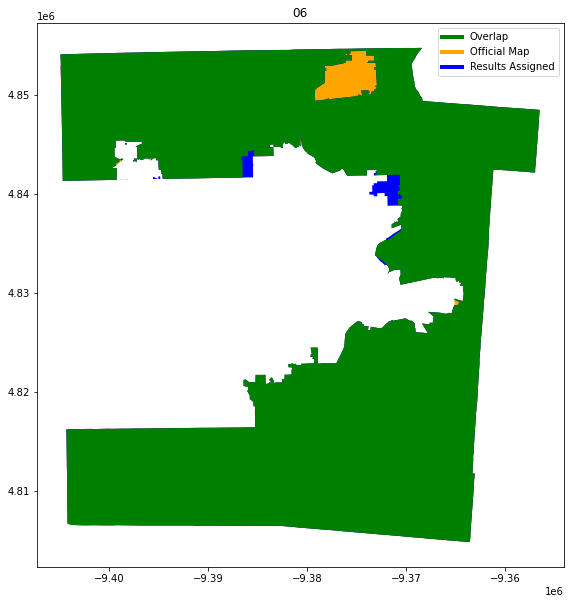

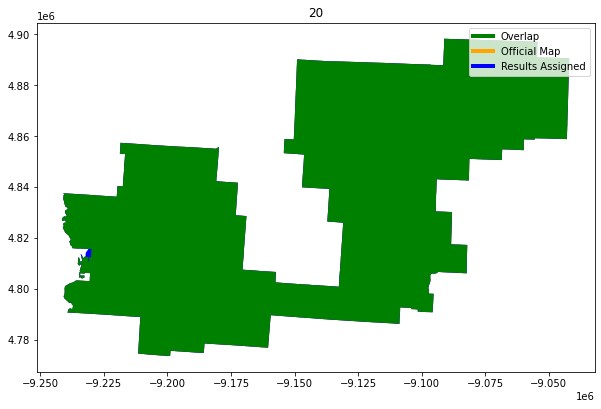

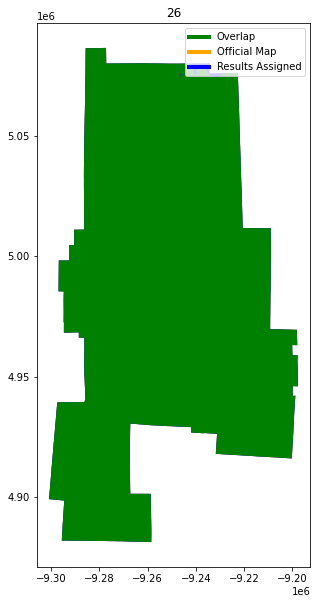

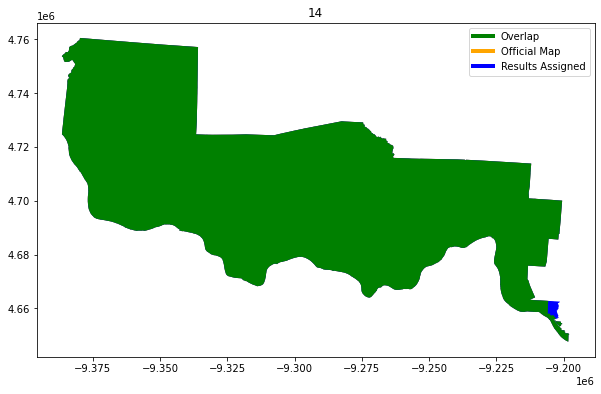

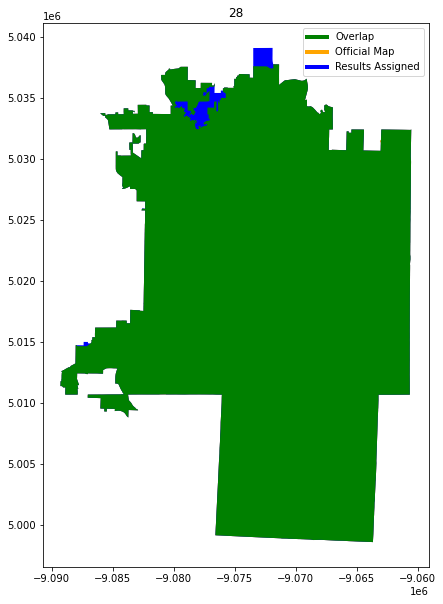

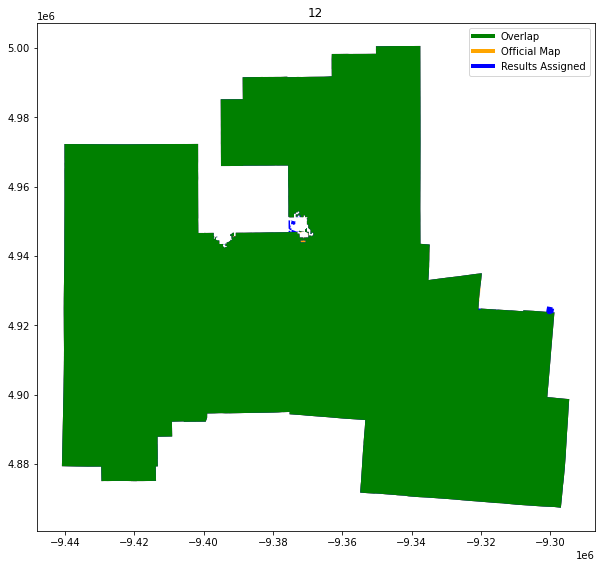

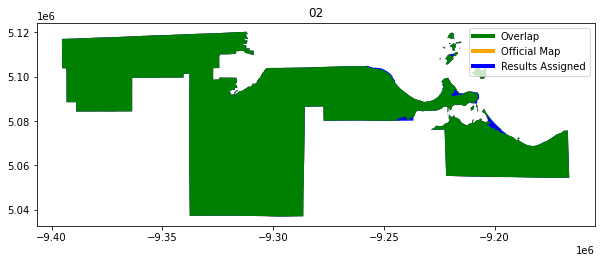

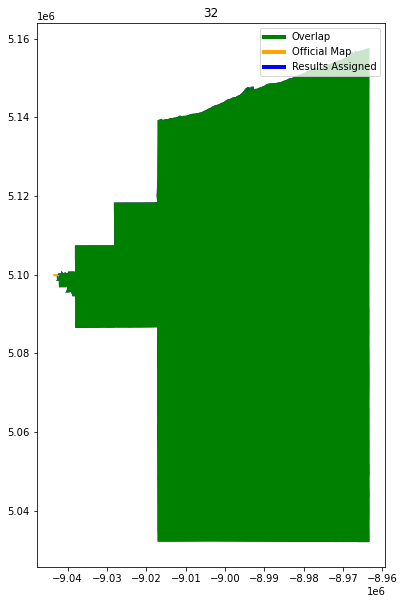

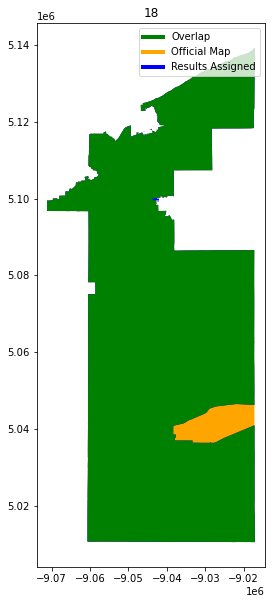

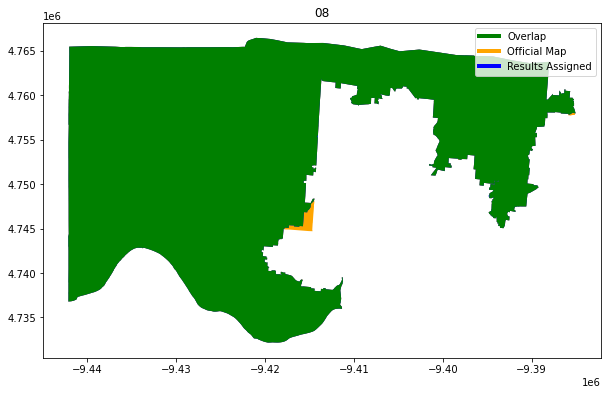

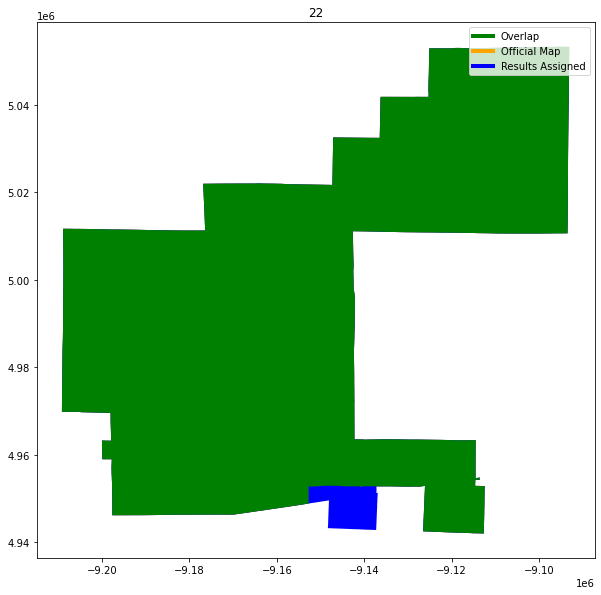

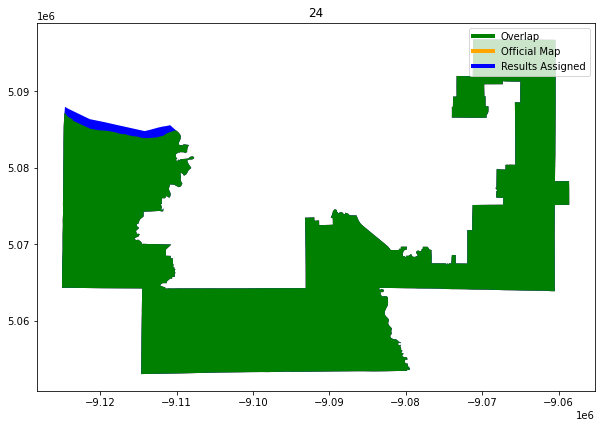

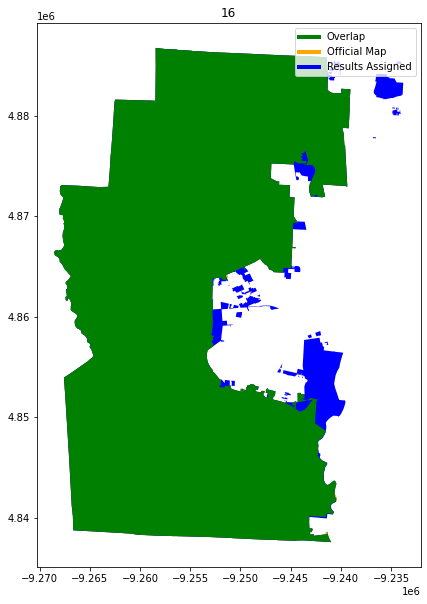

In [62]:
compare_geometries(filtered_sen,filtered_results,"Official Map","Results Assigned","SLDU_DIST",area_threshold=.1)

## Compare population totals against what the state has

In [63]:
tot_sum = 0
for val in final_race_list:
    print(val, sum(attempt_one[val]))
    tot_sum += sum(attempt_one[val])

PSU02DODO 12170
PSU02DSUB 11162
PSU04DWYE 12568
PSU06DFOG 16867
PSU06DGRI 3643
PSU08DBRO 18091
PSU10DBAL 16232
PSU12DPOL 10900
PSU14DOTT 13060
PSU16DBAI 1880
PSU16DDOU 4389
PSU16DLET 23349
PSU18DRAD 23183
PSU20DJOH 13993
PSU22DJOH 16506
PSU24DJAC 28496
PSU26DSWA 14208
PSU28DSYK 24995
PSU30DFLE 19731
PSU32DOBR 26151
PSU02RGAV 17352
PSU04RKEL 8318
PSU04RLAN 12579
PSU04RWON 4568
PSU06RANT 14866
PSU06RROB 2885
PSU06RSEL 5317
PSU08RBLE 20544
PSU10RHAC 29116
PSU12RHUF 33710
PSU14RJOH 29928
PSU14RUIB 9278
PSU16RKUN 13098
PSU18RCIR 23690
PSU20RSCH 25458
PSU22RBRA 3701
PSU22RFAL 6909
PSU22RHOV 726
PSU22RREY 1289
PSU22RROM 17629
PSU24RDOL 18161
PSU26RACK 13864
PSU26RREI 25363
PSU28RDOW 8626
PSU30RHOA 24726
PSU32ROBR 13519
PSU32RPOL 5983


702777 total sum matches

### Note: Checked these totals on 02/01/22 and they MATCH what the state has here: https://www.sos.state.oh.us/elections/election-results-and-data/

In [64]:
attempt_one.columns

Index(['UNIQUE_ID', 'COUNTYFP', 'STATEFP20', 'COUNTYFP20', 'VTDST20',
       'PRECINCT20', 'GEOID20', 'NAME20', 'PSU02DODO', 'PSU02DSUB',
       'PSU04DWYE', 'PSU06DFOG', 'PSU06DGRI', 'PSU08DBRO', 'PSU10DBAL',
       'PSU12DPOL', 'PSU14DOTT', 'PSU16DBAI', 'PSU16DDOU', 'PSU16DLET',
       'PSU18DRAD', 'PSU20DJOH', 'PSU22DJOH', 'PSU24DJAC', 'PSU26DSWA',
       'PSU28DSYK', 'PSU30DFLE', 'PSU32DOBR', 'PSU02RGAV', 'PSU04RKEL',
       'PSU04RLAN', 'PSU04RWON', 'PSU06RANT', 'PSU06RROB', 'PSU06RSEL',
       'PSU08RBLE', 'PSU10RHAC', 'PSU12RHUF', 'PSU14RJOH', 'PSU14RUIB',
       'PSU16RKUN', 'PSU18RCIR', 'PSU20RSCH', 'PSU22RBRA', 'PSU22RFAL',
       'PSU22RHOV', 'PSU22RREY', 'PSU22RROM', 'PSU24RDOL', 'PSU26RACK',
       'PSU26RREI', 'PSU28RDOW', 'PSU30RHOA', 'PSU32ROBR', 'PSU32RPOL',
       'geometry', 'County Name', 'Tot_Votes', 'SLDU_DIST'],
      dtype='object')

In [65]:
attempt_one = attempt_one[['UNIQUE_ID', 'COUNTYFP', 'STATEFP20', 'COUNTYFP20', 'VTDST20',
       'PRECINCT20', 'GEOID20', 'NAME20','SLDU_DIST', 'PSU02DODO', 'PSU02DSUB',
       'PSU04DWYE', 'PSU06DFOG', 'PSU06DGRI', 'PSU08DBRO', 'PSU10DBAL',
       'PSU12DPOL', 'PSU14DOTT', 'PSU16DBAI', 'PSU16DDOU', 'PSU16DLET',
       'PSU18DRAD', 'PSU20DJOH', 'PSU22DJOH', 'PSU24DJAC', 'PSU26DSWA',
       'PSU28DSYK', 'PSU30DFLE', 'PSU32DOBR', 'PSU02RGAV', 'PSU04RKEL',
       'PSU04RLAN', 'PSU04RWON', 'PSU06RANT', 'PSU06RROB', 'PSU06RSEL',
       'PSU08RBLE', 'PSU10RHAC', 'PSU12RHUF', 'PSU14RJOH', 'PSU14RUIB',
       'PSU16RKUN', 'PSU18RCIR', 'PSU20RSCH', 'PSU22RBRA', 'PSU22RFAL',
       'PSU22RHOV', 'PSU22RREY', 'PSU22RROM', 'PSU24RDOL', 'PSU26RACK',
       'PSU26RREI', 'PSU28RDOW', 'PSU30RHOA', 'PSU32ROBR', 'PSU32RPOL',
       'geometry']]

In [66]:
if not os.path.exists('./oh_prim_20_prec/'):
    os.mkdir('./oh_prim_20_prec/')

attempt_one.to_file('./oh_prim_20_prec/oh_prim_20_sldu_prec.shp')